In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
# Read data from the file
file = np.load('apogee_spectra_tutorial_week7b.npz')

# Extract spectral data
# `spectrum_array` contains the spectra for 6500 stars
spectra = file['spectrum_array']

# Extract wavelength data
# `wavelength` contains the wavelengths corresponding to the spectral features
wavelength = file['wavelength']

# Extract effective temperature for each star
# `teff_array` is our target variable for regression
teff_array = file['teff_array']

# Extract surface gravity and metallicity for informational purposes
# Note: These won't be used in our regression model for this tutorial
logg_array = file['logg_array']
feh_array = file['feh_array']

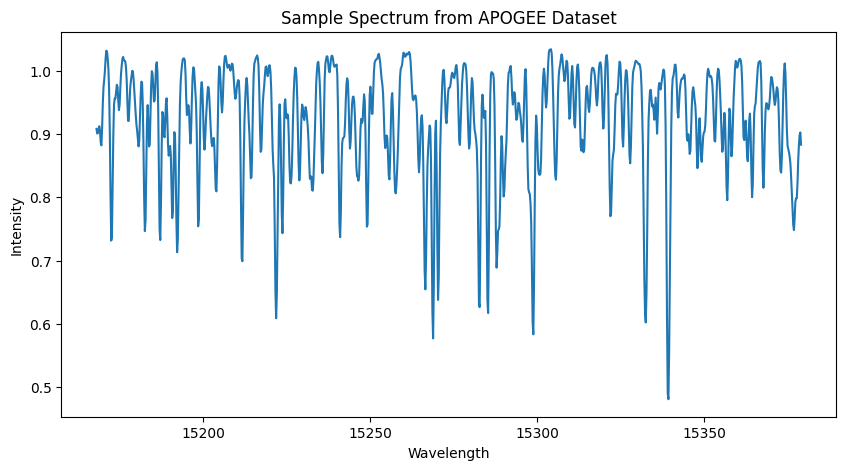

In [6]:
# Plot a portion of the normalized spectrum for the first star
# We are taking only the first 1000 data points for easier visualization
plt.figure(figsize=(10, 5)) 
plt.plot(wavelength[:1000], spectra[0][:1000])

# Adding labels and title for better understanding of the plot
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.title('Sample Spectrum from APOGEE Dataset')

# Show the plot
plt.show()

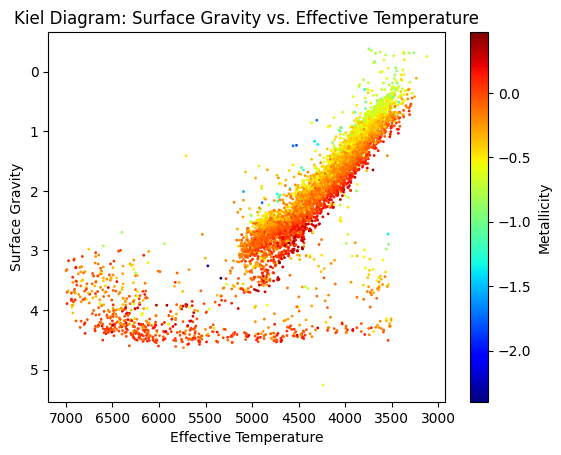

In [36]:
# Create a scatter plot of Surface Gravity vs Effective Temperature, color-coded by Metallicity
plt.scatter(teff_array, logg_array, c=feh_array, cmap='jet', s=1)

# Label axes and add a title
plt.xlabel('Effective Temperature')
plt.ylabel('Surface Gravity')
plt.title('Kiel Diagram: Surface Gravity vs. Effective Temperature')
plt.colorbar(label='Metallicity')

# Invert the x and y axes for traditional presentation
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [13]:
# Use spectra as the design matrix and limit to first 2000 pixels
Phi = spectra[:,:2000]

# Add a column of ones to the design matrix to act as the bias term
Phi = np.hstack((Phi, np.ones((Phi.shape[0], 1))))
print("Shape of design matrix Phi:", Phi.shape)

# Use effective temperature as the target variable
t = teff_array
print("Shape of target array t:", t.shape)

Shape of design matrix Phi: (6500, 2001)
Shape of target array t: (6500,)


In [14]:
# Import the train_test_split function from sklearn
from sklearn.model_selection import train_test_split

# Split the data into training and test setsb
Phi_train, Phi_test, t_train, t_test = train_test_split(Phi, t, test_size=0.2)

In [10]:
# Compute the Maximum Likelihood weights using the analytical solution
w_ml = np.linalg.inv(Phi_train.T @ Phi_train) @ Phi_train.T @ t_train

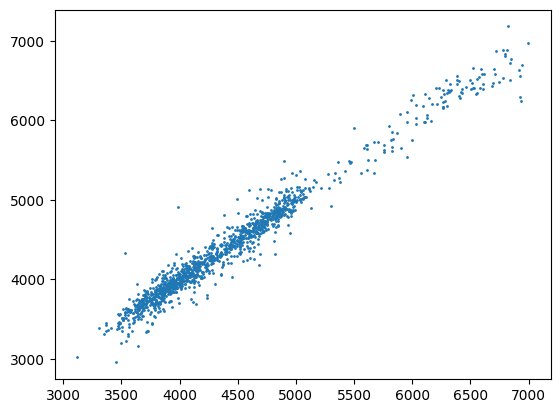

In [11]:
# Make predictions on the test set using the ML weights
t_pred = Phi_test @ w_ml

# Plot the actual vs predicted values
plt.scatter(t_test, t_pred, s=1)

In [18]:
# Calculate the RMSE for the training and test sets
train_RMSE = np.sqrt(np.mean((t_train - Phi_train @ w_ml)**2))
test_RMSE = np.sqrt(np.mean((t_test - t_pred)**2))

# Display the RMSE values
print(f"Training RMSE: {train_RMSE:.2f}")
print(f"Test RMSE: {test_RMSE:.2f}")

Training RMSE: 86.08
Test RMSE: 1014.82


In [19]:
# Define a function to calculate mean of the posterior for a regularized linear regression
def w_ml_regularised(l):
    return np.linalg.inv(l * np.eye(Phi_train.shape[1]) + Phi_train.T @ Phi_train) @ Phi_train.T @ t_train

<>:24: SyntaxWarning: invalid escape sequence '\l'
<>:27: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\l'
<>:27: SyntaxWarning: invalid escape sequence '\l'
/var/folders/jp/5s_9hd2d4_5gkkj4yxpty2200000gp/T/ipykernel_48926/1983561081.py:24: SyntaxWarning: invalid escape sequence '\l'
  plt.title('RMSE vs Regularisation parameter $\lambda$')
/var/folders/jp/5s_9hd2d4_5gkkj4yxpty2200000gp/T/ipykernel_48926/1983561081.py:27: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('log($\lambda$)')


Training model for log lambda = -2.00
Training model for log lambda = -1.73
Training model for log lambda = -1.47
Training model for log lambda = -1.20
Training model for log lambda = -0.93
Training model for log lambda = -0.67
Training model for log lambda = -0.40
Training model for log lambda = -0.13
Training model for log lambda = 0.13
Training model for log lambda = 0.40
Training model for log lambda = 0.67
Training model for log lambda = 0.93
Training model for log lambda = 1.20
Training model for log lambda = 1.47
Training model for log lambda = 1.73
Training model for log lambda = 2.00


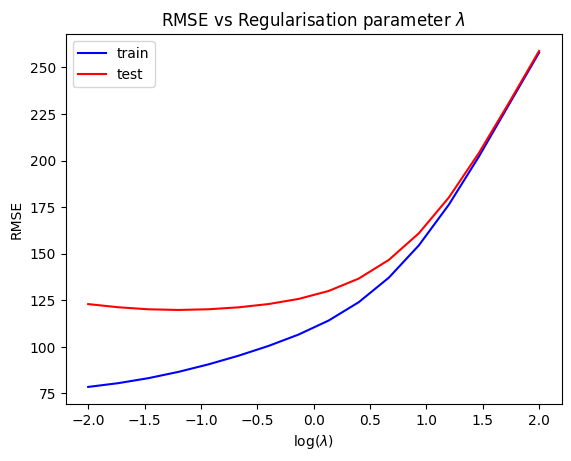

In [21]:
# Define a range of log-scaled lambda values
log_lambdas = np.linspace(-2, 2, 16)

# Initialize an array to store the results. 
# The first column will contain RMSE for training data and the second for test data.
results = np.zeros((len(log_lambdas), 2))

# Loop over each hyperparameter value and train the model
for ix, l in enumerate(log_lambdas):
    print(f"Training model for log lambda = {float(l):.2f}")

    # Compute the regularized weight vector
    w_reg = w_ml_regularised(pow(10,float(l)))

    # Calculate RMSE for training and test sets
    rmse_train = np.sqrt(np.mean((t_train - Phi_train @ w_reg)**2))
    rmse_test = np.sqrt(np.mean((t_test - Phi_test @ w_reg)**2))

    # Store the results
    results[ix, 0] = rmse_train
    results[ix, 1] = rmse_test

# Plot the RMSE values as a function of lambda
plt.title('RMSE vs Regularisation parameter $\lambda$')
plt.plot(log_lambdas, results[:,0], 'b-', label='train')  # Training data
plt.plot(log_lambdas, results[:,1], 'r-', label='test')  # Test data
plt.xlabel('log($\lambda$)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [23]:
# the best RMSE is achieved at the minimum of the test curve
best_lambda = pow(10, log_lambdas[np.argmin(results[:,1])])
print(f"Best lambda: {best_lambda:.2f}")
print(f"Best test RMSE: {np.min(results[:, 1]):.2f}")

Best lambda: 0.06
Best test RMSE: 119.79


In [25]:
def phi_quadratic(x):    
    return np.hstack((x, x**2))

In [27]:
# Extend the feature set
Phi_quad_train = np.array([phi_quadratic(Phi_train[i]) for i in range(Phi_train.shape[0])])
Phi_quad_test = np.array([phi_quadratic(Phi_test[i]) for i in range(Phi_test.shape[0])])

# Remove the extra bias term
Phi_quad_train = Phi_quad_train[:,:-1]
Phi_quad_test = Phi_quad_test[:,:-1]

# Train the model
w_unreg = np.linalg.inv(Phi_quad_train.T @ Phi_quad_train) @ Phi_quad_train.T @ t_train
t_train_pred = np.dot(Phi_quad_train, w_unreg)
t_test_pred = np.dot(Phi_quad_test, w_unreg)

# Calculate RMSE
train_rmse = np.sqrt(np.mean((t_train - t_train_pred)**2))
test_rmse = np.sqrt(np.mean((t_test - t_test_pred)**2))

print(f"RMSE with basis functions and without regularisation: Train {train_rmse:.2f}, Test {test_rmse:.2f}")

RMSE with basis functions and without regularisation: Train 18.08, Test 184.54


<>:19: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/var/folders/jp/5s_9hd2d4_5gkkj4yxpty2200000gp/T/ipykernel_48926/2648435073.py:19: SyntaxWarning: invalid escape sequence '\l'
  plt.title('RMSE vs Regularisation parameter $\lambda$')
/var/folders/jp/5s_9hd2d4_5gkkj4yxpty2200000gp/T/ipykernel_48926/2648435073.py:22: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('log($\lambda$)')


Training model for log lambda = -2.00
Training model for log lambda = -1.73
Training model for log lambda = -1.47
Training model for log lambda = -1.20
Training model for log lambda = -0.93
Training model for log lambda = -0.67
Training model for log lambda = -0.40
Training model for log lambda = -0.13
Training model for log lambda = 0.13
Training model for log lambda = 0.40
Training model for log lambda = 0.67
Training model for log lambda = 0.93
Training model for log lambda = 1.20
Training model for log lambda = 1.47
Training model for log lambda = 1.73
Training model for log lambda = 2.00


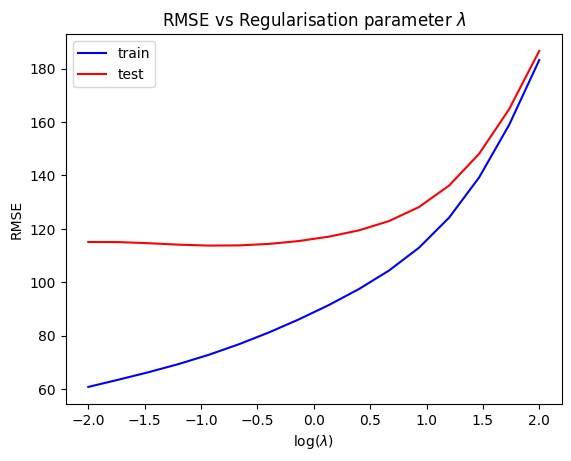

In [29]:
# Function to calculate the weight vector for a regularized linear regression
def w_ml_regularised(l):
    return np.linalg.inv(l * np.eye(Phi_quad_train.shape[1]) + Phi_quad_train.T @ Phi_quad_train) @ Phi_quad_train.T @ t_train

# Initialize the search grid for lambda values
log_lambdas = np.linspace(-2, 2, 16)
results = np.zeros((len(log_lambdas), 2))

# Perform grid search
for ix, l in enumerate(log_lambdas):
    print(f"Training model for log lambda = {float(l):.2f}")
    w_reg = w_ml_regularised(pow(10,float(l)))
    rmse_train = np.sqrt(np.mean((t_train - Phi_quad_train @ w_reg)**2))
    rmse_test = np.sqrt(np.mean((t_test - Phi_quad_test @ w_reg)**2))
    results[ix, 0] = rmse_train
    results[ix, 1] = rmse_test

# Plotting
plt.title('RMSE vs Regularisation parameter $\lambda$')
plt.plot(log_lambdas, results[:,0], 'b-', label='train')
plt.plot(log_lambdas, results[:,1], 'r-', label='test')
plt.xlabel('log($\lambda$)')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [31]:
# the best RMSE is achieved at the minimum of the test curve
best_lambda = pow(10, log_lambdas[np.argmin(results[:,1])])
print(f"Best lambda: {best_lambda:.2f}")
print(f"Best test RMSE: {np.min(results[:,1]):.2f}")

Best lambda: 0.12
Best test RMSE: 113.71


In [119]:
# Define regularization parameter lambda 
# we use the best_lambda value from the above 
lambda_reg = 0.12

# Compute regularized w_ml
m_N = np.linalg.inv(lambda_reg * np.eye(Phi_train.shape[1]) + Phi_train.T @ Phi_train) @ Phi_train.T @ t_train

# Assuming the noise precision beta is estimated as:
N = len(t_train)
beta = N / np.sum((t_train - Phi_train @ m_N)**2)

# Compute the posterior covariance S with regularization
S_inv = Phi_train.T @ Phi_train + (1/beta + lambda_reg) * np.eye(Phi_train.shape[1])
S_N = np.linalg.inv(S_inv)

# Initialize arrays for predictive means and variances
pred_means = np.zeros(Phi_test.shape[0])
pred_vars = np.zeros(Phi_test.shape[0])

# Calculate the predictive distributions for the test set
for i in range(Phi_test.shape[0]):
    pred_means[i] = Phi_test[i] @ m_N
    pred_vars[i] = 1/beta + Phi_test[i].T @ S_N @ Phi_test[i]

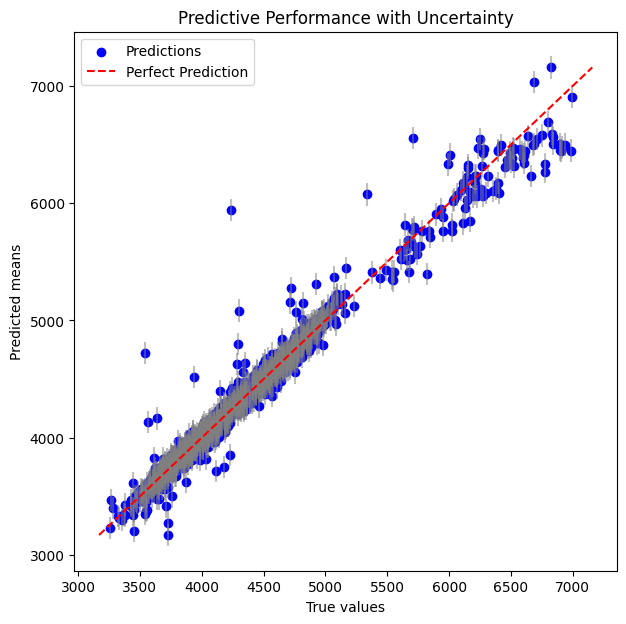

In [33]:
# Convert predictive variance to standard deviation for plotting
pred_stds = np.sqrt(pred_vars)

# Create scatter plot
plt.figure(figsize=(7, 7))
plt.scatter(t_test, pred_means, c='blue', marker='o', label='Predictions')

# Add error bars to indicate predictive uncertainty
plt.errorbar(t_test, pred_means, yerr=pred_stds, fmt='none', ecolor='gray', alpha=0.5)

# Plot a line for perfect predictions
min_val = min(np.min(t_test), np.min(pred_means))
max_val = max(np.max(t_test), np.max(pred_means))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

# Add labels and legend
plt.xlabel('True values')
plt.ylabel('Predicted means')
plt.title('Predictive Performance with Uncertainty')
plt.legend()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture


In [15]:
# Parameters for the synthetic data
np.random.seed(42)
n_samples = 500
means = np.array([[0, 0], [3, 3], [0, 3]])
covariances = np.array([[[0.1, 0], [0, 0.8]], 
                        [[0.5, 0], [0, 0.5]], 
                        [[0.5, 0], [0, 0.5]]])
weights = [0.1, 0.7, 0.2]

# Generate synthetic data
data = []
for i in range(len(weights)):
    data.append(np.random.multivariate_normal(means[i], covariances[i], int(n_samples * weights[i])))
data = np.vstack(data)


In [16]:
# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(data)


GaussianMixture(n_components=3, random_state=42)

In [17]:
# Generate new samples from the fitted GMM
n_new_samples = 500
new_samples, _ = gmm.sample(n_new_samples)


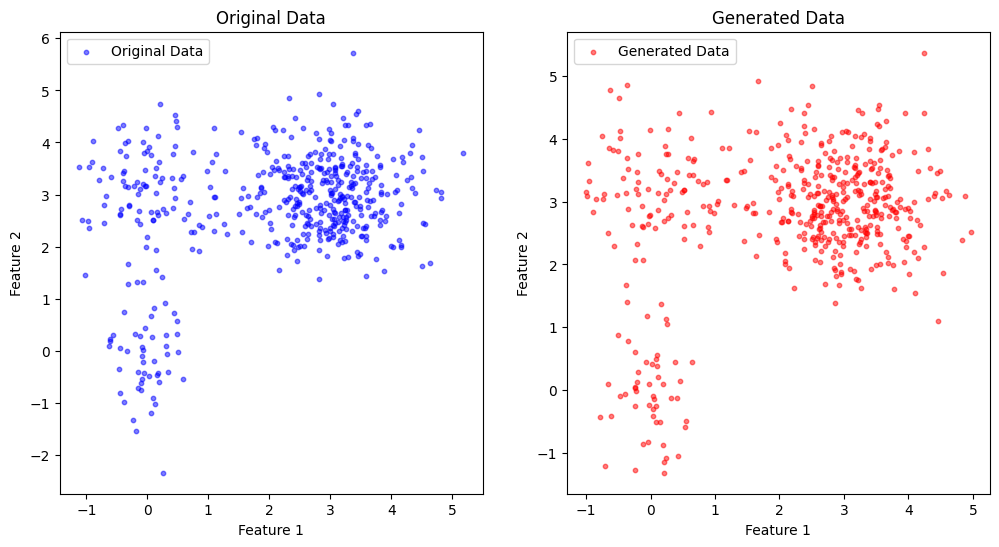

In [18]:
# Plot the original and generated data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], s=10, color='blue', alpha=0.5, label='Original Data')
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(new_samples[:, 0], new_samples[:, 1], s=10, color='red', alpha=0.5, label='Generated Data')
plt.title('Generated Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.show()


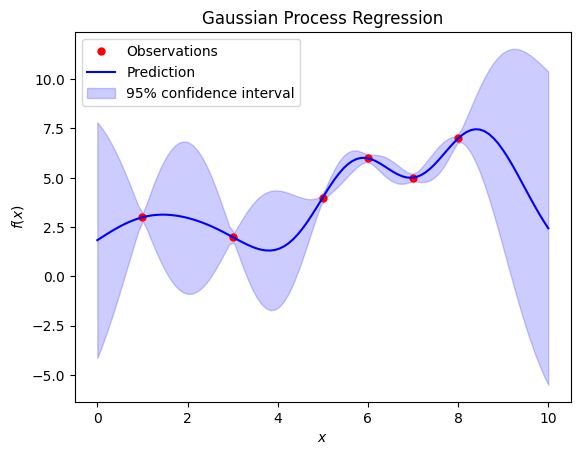

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Generate sample data
X = np.array([[1], [3], [5], [6], [7], [8]]).astype(float)
y = np.array([3, 2, 4, 6, 5, 7]).astype(float)

# Define kernel (RBF kernel with a constant kernel)
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))

# Create Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# Fit to the data
gp.fit(X, y)

# Make predictions
X_ = np.linspace(0, 10, 100).reshape(-1, 1)
y_pred, sigma = gp.predict(X_, return_std=True)

# Plot results
plt.figure()
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(X_, y_pred, 'b-', label='Prediction')
plt.fill_between(X_[:, 0], y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.2, color='blue', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.title('Gaussian Process Regression')
plt.show()


/Users/sophia268238/GitHub/astronomy_ml/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/sophia268238/GitHub/astronomy_ml/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


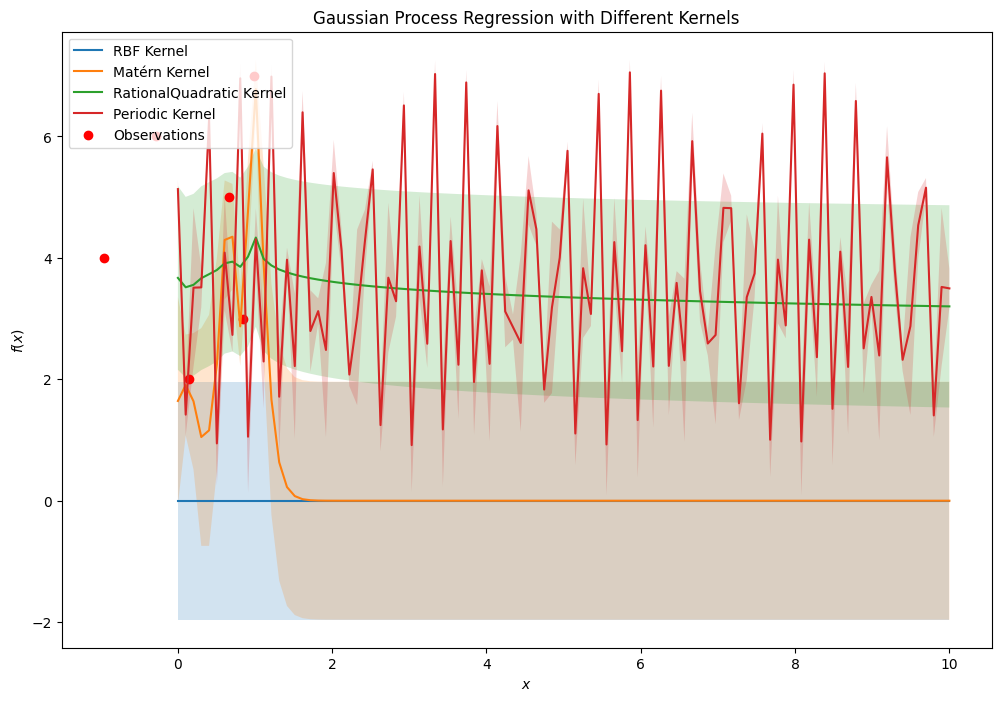

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared

# Generate sample data
X = np.array([[1], [3], [5], [6], [7], [8]]).astype(float)
y = np.array([3, 2, 4, 6, 5, 7]).astype(float)

# Define different kernels
kernels = {
    "RBF": RBF(length_scale=1.0),
    "Matérn": Matern(length_scale=1.0, nu=1.5),
    "RationalQuadratic": RationalQuadratic(length_scale=1.0, alpha=0.1),
    "Periodic": ExpSineSquared(length_scale=1.0, periodicity=3.0)
}

X_ = np.linspace(0, 10, 100).reshape(-1, 1)

# Fit and plot predictions for each kernel
plt.figure(figsize=(12, 8))
for name, kernel in kernels.items():
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
    gp.fit(X, y)
    y_pred, sigma = gp.predict(X_, return_std=True)

    plt.plot(X_, y_pred, label=f'{name} Kernel')
    plt.fill_between(X_[:, 0], y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.2)

plt.scatter(X, y, c='r', label='Observations')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.title('Gaussian Process Regression with Different Kernels')
plt.show()


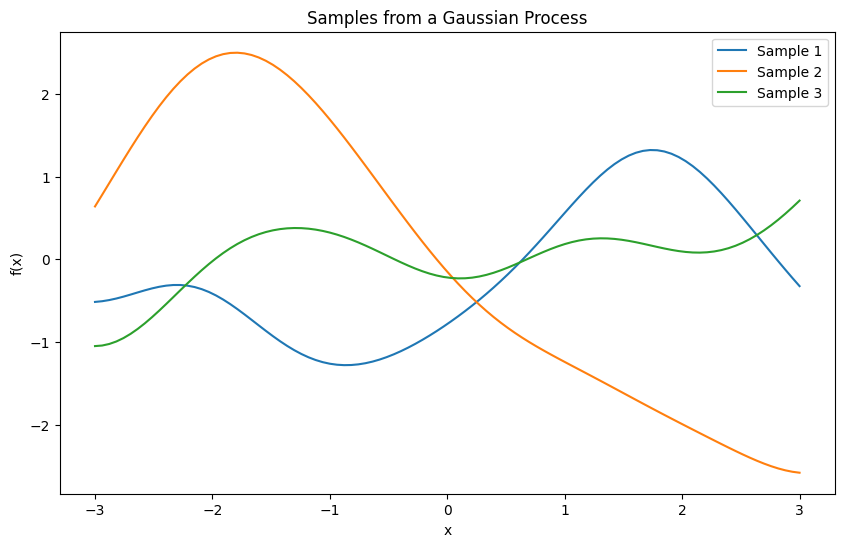

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Define the mean and covariance functions
def mean_function(x):
    return np.zeros_like(x)

def covariance_function(x, x_prime):
    return np.exp(-0.5 * (x - x_prime)**2)

# Choose input points
x = np.linspace(-3, 3, 100)

# Construct the mean vector and covariance matrix
mean_vector = mean_function(x)
covariance_matrix = np.array([[covariance_function(xi, xj) for xj in x] for xi in x])

# Draw samples from the multivariate Gaussian distribution
num_samples = 3
samples = np.random.multivariate_normal(mean_vector, covariance_matrix, num_samples)

# Plot the sampled functions
plt.figure(figsize=(10, 6))
for i in range(num_samples):
    plt.plot(x, samples[i], label=f'Sample {i+1}')
plt.title('Samples from a Gaussian Process')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()
